In [22]:
# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np
from datetime import datetime

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Bibliotecas para pré-processamento
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression

# Bibliotecas para os modelos de regressão
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score

# Bibliotecas para análise avançada
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

# Configurações para os gráficos
plt.style.use('seaborn-v0_8')
sns.set(style="whitegrid", font_scale=1.1)
%matplotlib inline

# Verificação da versão do scikit-learn
from sklearn import __version__ as sklearn_version
print(f"Versão do scikit-learn: {sklearn_version}")

Versão do scikit-learn: 1.6.1


Preparação dos Dados e Engenharia de Features

Colunas disponíveis no dataset:
['Chutes a gol 1', 'Chutes a gol 2', 'Impedimentos 1', 'Impedimentos 2', 'Escanteios 1', 'Escanteios 2', 'Chutes fora 1', 'Chutes fora 2', 'Faltas 1', 'Faltas 2', 'Cartões amarelos 1', 'Cartões amarelos 2', 'Cartões vermelhos 1', 'Cartões vermelhos 2', 'Cruzamentos 1', 'Cruzamentos 2', 'Laterais 1', 'Laterais 2', 'Chutes bloqueados 1', 'Chutes bloqueados 2', 'Contra-ataques 1', 'Contra-ataques 2', 'Gols 1', 'Gols 2', 'Tiro de meta 1', 'Tiro de meta 2', 'Tratamentos 1', 'Tratamentos 2', 'Substituições 1', 'Substituições 2', 'Tiros-livres 1', 'Tiros-livres 2', 'Defesas difíceis 1', 'Defesas difíceis 2', 'Posse 1(%)', 'Posse 2(%)', 'Time 1', 'Time 2', 'Position 1', 'Position 2', 'Taxa_conversao_1', 'Taxa_conversao_2', 'Eficiencia_posse_1', 'Eficiencia_posse_2', 'Vitoria_Time1', 'Empate', 'Vitoria_Time2']
Codificando variáveis categóricas...
Há valores nulos nas features:
Posse 1(%)             1
Posse 2(%)             1
Diff_Posse             1
Diff_Taxa_Co

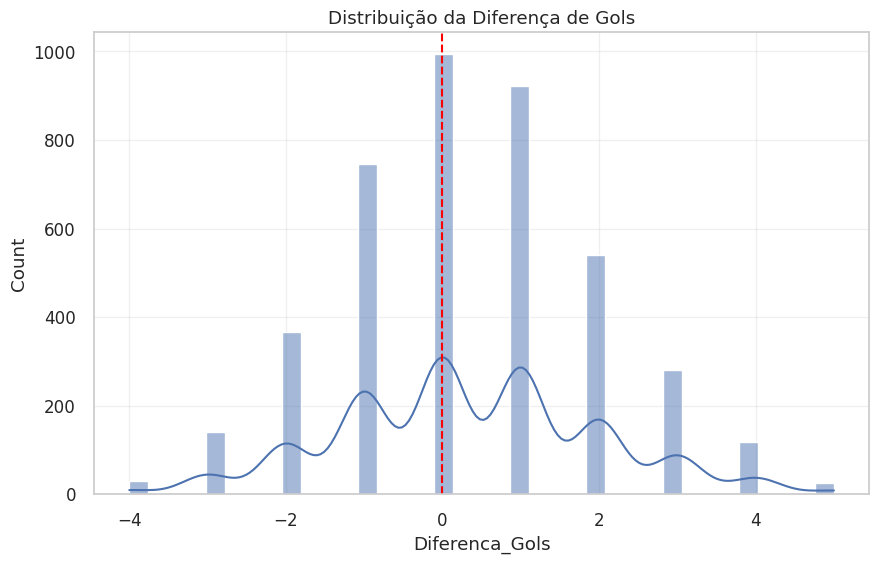


Estatísticas descritivas da diferença de gols:
count    4161.000000
mean        0.343667
std         1.669765
min        -4.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: Diferenca_Gols, dtype: float64

Contagem de resultados:
Resultado
0    1281
1     994
2    1886
Name: count, dtype: int64


In [23]:
# Criando uma cópia para não modificar os dados originais
df = campeonatos.copy()

# Verificando as colunas disponíveis
print("Colunas disponíveis no dataset:")
print(df.columns.tolist())

# Criando a variável alvo para regressão: diferença de gols (time 1 - time 2)
df['Diferenca_Gols'] = df['Gols 1'] - df['Gols 2']

# Mantendo também a variável categorica original para referência
def criar_resultado(row):
    if row['Gols 1'] > row['Gols 2']:
        return 2  # Vitória Time 1
    elif row['Gols 1'] == row['Gols 2']:
        return 1  # Empate
    else:
        return 0  # Vitória Time 2

df['Resultado'] = df.apply(criar_resultado, axis=1)

# Criando features adicionais que possam ter valor preditivo
# Diferença de chutes a gol
df['Diff_Chutes_Gol'] = df['Chutes a gol 1'] - df['Chutes a gol 2']
# Diferença de posse de bola
df['Diff_Posse'] = df['Posse 1(%)'] - df['Posse 2(%)']
# Diferença de escanteios
df['Diff_Escanteios'] = df['Escanteios 1'] - df['Escanteios 2']
# Diferença de faltas
df['Diff_Faltas'] = df['Faltas 1'] - df['Faltas 2']
# Eficiência ofensiva: razão entre chutes a gol e total de chutes
df['Eficiencia_Ofensiva_1'] = df['Chutes a gol 1'] / (df['Chutes a gol 1'] + df['Chutes fora 1'] + 1e-5)
df['Eficiencia_Ofensiva_2'] = df['Chutes a gol 2'] / (df['Chutes a gol 2'] + df['Chutes fora 2'] + 1e-5)
df['Diff_Eficiencia_Ofensiva'] = df['Eficiencia_Ofensiva_1'] - df['Eficiencia_Ofensiva_2']
# Diferença nas taxas de conversão
if 'Taxa_conversao_1' in df.columns and 'Taxa_conversao_2' in df.columns:
    df['Diff_Taxa_Conversao'] = df['Taxa_conversao_1'] - df['Taxa_conversao_2']

# Codificação one-hot para formações táticas
print("Codificando variáveis categóricas...")

# Para Position 1
try:
    # Para scikit-learn >= 1.2.0
    ohe_time1 = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
except TypeError:
    # Para scikit-learn < 1.2.0
    ohe_time1 = OneHotEncoder(sparse=False, handle_unknown='ignore')

if 'Position 1' in df.columns:
    formacoes_time1 = ohe_time1.fit_transform(df[['Position 1']])
    formacoes_colunas1 = [f"Time1_Form_{cat}" for cat in ohe_time1.categories_[0]]
    df_formacoes1 = pd.DataFrame(formacoes_time1, columns=formacoes_colunas1, index=df.index)

    # Para Position 2
    ohe_time2 = ohe_time1.__class__(**ohe_time1.get_params())
    formacoes_time2 = ohe_time2.fit_transform(df[['Position 2']])
    formacoes_colunas2 = [f"Time2_Form_{cat}" for cat in ohe_time2.categories_[0]]
    df_formacoes2 = pd.DataFrame(formacoes_time2, columns=formacoes_colunas2, index=df.index)

    # Concatenando com o DataFrame principal
    df = pd.concat([df, df_formacoes1, df_formacoes2], axis=1)

# Selecionando features para o modelo - não incluímos gols diretamente
features = [
    # Métricas básicas de jogo
    'Chutes a gol 1', 'Chutes a gol 2', 'Impedimentos 1', 'Impedimentos 2',
    'Escanteios 1', 'Escanteios 2', 'Chutes fora 1', 'Chutes fora 2',
    'Faltas 1', 'Faltas 2', 'Cartões amarelos 1', 'Cartões amarelos 2',
    'Posse 1(%)', 'Posse 2(%)',

    # Features derivadas
    'Diff_Chutes_Gol', 'Diff_Posse', 'Diff_Escanteios', 'Diff_Faltas',
    'Eficiencia_Ofensiva_1', 'Eficiencia_Ofensiva_2', 'Diff_Eficiencia_Ofensiva'
]

# Verificar se existem essas colunas no DataFrame
features = [f for f in features if f in df.columns]

# Adicionar Diff_Taxa_Conversao apenas se existir
if 'Diff_Taxa_Conversao' in df.columns:
    features.append('Diff_Taxa_Conversao')

# Adicionando as colunas de formações táticas
formacoes = [col for col in df.columns if col.startswith('Time1_Form_') or col.startswith('Time2_Form_')]
features.extend(formacoes)

# Verificando se há valores NaN nas features
nulos = df[features].isnull().sum()
if nulos.sum() > 0:
    print("Há valores nulos nas features:")
    print(nulos[nulos > 0])
    print("Imputando valores nulos com a mediana...")
    for col in nulos[nulos > 0].index:
        df[col] = df[col].fillna(df[col].median())

print(f"Preparação dos dados concluída. Número de features selecionadas: {len(features)}")

# Mostrar distribuição da diferença de gols
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Diferenca_Gols', kde=True)
plt.title('Distribuição da Diferença de Gols')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(alpha=0.3)
plt.show()

# Estatísticas descritivas da variável alvo
print("\nEstatísticas descritivas da diferença de gols:")
print(df['Diferenca_Gols'].describe())

# Contagem de resultados por categoria
print("\nContagem de resultados:")
print(df['Resultado'].value_counts().sort_index())

Divisão em Conjuntos de Treino e Teste

In [24]:
# Definindo X e y para nossa análise de regressão
X = df[features]
y = df['Diferenca_Gols']

# Verificando a distribuição da variável alvo
print("Distribuição da variável alvo (diferença de gols):")
print(y.value_counts().sort_index())
print(f"Valores únicos: {len(y.unique())}")

# Divisão estratificada em conjuntos de treino e teste
# Como estamos trabalhando com regressão, podemos usar shuffle=True
# Vamos usar 80% para treino e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Alternativamente, se você quiser manter a ordem cronológica:
# Supondo que o DataFrame está em ordem cronológica
# train_size = int(0.8 * len(df))
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# Escalonando as features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicando seleção de features se o dataset for grande
if X.shape[1] > 20:  # Se tivermos mais de 20 features
    print("\nRealizando seleção de features...")
    selector = SelectKBest(score_func=f_regression, k=min(20, len(features)))
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    # Identificando quais features foram selecionadas
    selected_indices = selector.get_support(indices=True)
    selected_features = [features[i] for i in selected_indices]

    print("\nFeatures selecionadas:")
    feature_scores = {features[i]: selector.scores_[i] for i in range(len(features))}
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
    for feature, score in sorted_features[:20]:
        print(f"- {feature}: {score:.2f}")
else:
    X_train_selected = X_train_scaled
    X_test_selected = X_test_scaled
    selected_features = features
    selected_indices = range(len(features))

print(f"\nDivisão dos dados concluída. Dimensões: X_train: {X_train_selected.shape}, X_test: {X_test_selected.shape}")

Distribuição da variável alvo (diferença de gols):
Diferenca_Gols
-4.0     29
-3.0    141
-2.0    366
-1.0    745
 0.0    994
 1.0    921
 2.0    540
 3.0    281
 4.0    118
 5.0     26
Name: count, dtype: int64
Valores únicos: 10

Realizando seleção de features...

Features selecionadas:
- Diff_Chutes_Gol: 1081.36
- Chutes a gol 1: 557.45
- Diff_Eficiencia_Ofensiva: 444.73
- Chutes a gol 2: 441.49
- Eficiencia_Ofensiva_2: 200.46
- Eficiencia_Ofensiva_1: 166.36
- Cartões amarelos 1: 73.74
- Diff_Posse: 40.02
- Posse 1(%): 40.02
- Posse 2(%): 40.02
- Time1_Form_4-3-3: 23.45
- Time2_Form_4-2-3-1: 16.40
- Time1_Form_4-5-1: 13.18
- Time1_Form_4-2-3-1: 11.92
- Chutes fora 1: 9.65
- Time1_Form_3-5-2: 9.49
- Time2_Form_4-3-1-2: 7.49
- Escanteios 2: 6.64
- Time2_Form_3-5-2: 6.11
- Cartões amarelos 2: 5.89

Divisão dos dados concluída. Dimensões: X_train: (3328, 20), X_test: (833, 20)


Implementação e Avaliação da Regressão Logística

In [25]:
# Funções para avaliação de modelos de regressão
def evaluate_regression_model(y_true, y_pred, model_name="Modelo"):
    """
    Avalia um modelo de regressão usando várias métricas.

    Args:
        y_true: Valores reais
        y_pred: Valores previstos
        model_name: Nome do modelo para identificação

    Returns:
        dict: Dicionário com todas as métricas calculadas
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)

    # Cálculo do MAPE e SMAPE (tratando divisões por zero)
    y_true_abs = np.abs(y_true)
    mask = y_true_abs > 1e-10  # Para evitar divisão por zero

    if np.any(mask):
        # MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true_abs[mask])) * 100

        # SMAPE (Symmetric Mean Absolute Percentage Error)
        smape = np.mean(2.0 * np.abs(y_pred[mask] - y_true[mask]) /
                        (np.abs(y_true[mask]) + np.abs(y_pred[mask]) + 1e-10)) * 100
    else:
        mape = np.nan
        smape = np.nan

    print(f"Avaliação do {model_name}:")
    print(f"R² (Coeficiente de Determinação): {r2:.4f}")
    print(f"MSE (Erro Quadrático Médio): {mse:.4f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")
    print(f"MAE (Erro Absoluto Médio): {mae:.4f}")
    print(f"MedAE (Erro Absoluto Mediano): {medae:.4f}")
    if not np.isnan(mape):
        print(f"MAPE (Erro Percentual Absoluto Médio): {mape:.4f}%")
        print(f"SMAPE (Erro Percentual Absoluto Médio Simétrico): {smape:.4f}%")
    print(f"EVS (Variância Explicada): {evs:.4f}")

    return {
        'r2': r2,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'medae': medae,
        'mape': mape,
        'smape': smape,
        'evs': evs
    }

# Função para plot de resíduos de regressão
def plot_residuals(y_true, y_pred, model_name="Modelo"):
    """
    Gera gráficos para análise de resíduos do modelo de regressão.

    Args:
        y_true: Valores reais
        y_pred: Valores previstos
        model_name: Nome do modelo para identificação
    """
    residuals = y_true - y_pred

    plt.figure(figsize=(16, 12))

    # Plot de resíduos vs valores previstos
    plt.subplot(2, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'Resíduos vs Valores Preditos - {model_name}')
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    plt.grid(alpha=0.3)

    # Histograma dos resíduos
    plt.subplot(2, 2, 2)
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f'Distribuição dos Resíduos - {model_name}')
    plt.xlabel('Resíduos')
    plt.axvline(x=0, color='r', linestyle='-')
    plt.grid(alpha=0.3)

    # QQ-plot para verificar normalidade dos resíduos
    plt.subplot(2, 2, 3)
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot dos Resíduos - {model_name}')
    plt.grid(alpha=0.3)

    # Valores reais vs preditos
    plt.subplot(2, 2, 4)
    # Criar linhas de referência para diferentes resultados
    plt.axvspan(-10, 0, alpha=0.1, color='blue', label='Vitória Time 2')
    plt.axvspan(0, 0.001, alpha=0.1, color='gray', label='Empate')
    plt.axvspan(0.001, 10, alpha=0.1, color='green', label='Vitória Time 1')

    plt.scatter(y_true, y_pred, alpha=0.6)

    # Linha de igualdade
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title(f'Valores Reais vs Preditos - {model_name}')
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Preditos')
    plt.grid(alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

Implementação e Avaliação do SVR


Treinando e avaliando modelos de regressão para diferença de gols...

Treinando modelo Regressão Linear...
Avaliação do Regressão Linear:
R² (Coeficiente de Determinação): 0.2326
MSE (Erro Quadrático Médio): 2.0723
RMSE (Raiz do Erro Quadrático Médio): 1.4395
MAE (Erro Absoluto Médio): 1.1568
MedAE (Erro Absoluto Mediano): 0.9922
MAPE (Erro Percentual Absoluto Médio): 82.8217%
SMAPE (Erro Percentual Absoluto Médio Simétrico): 119.8881%
EVS (Variância Explicada): 0.2326
Tempo de execução: 0:00:00.052428

Treinando modelo Ridge...
Avaliação do Ridge:
R² (Coeficiente de Determinação): 0.2326
MSE (Erro Quadrático Médio): 2.0722
RMSE (Raiz do Erro Quadrático Médio): 1.4395
MAE (Erro Absoluto Médio): 1.1568
MedAE (Erro Absoluto Mediano): 0.9921
MAPE (Erro Percentual Absoluto Médio): 82.8197%
SMAPE (Erro Percentual Absoluto Médio Simétrico): 119.8899%
EVS (Variância Explicada): 0.2326
Tempo de execução: 0:00:00.010674

Treinando modelo Lasso...
Avaliação do Lasso:
R² (Coeficiente de Determin

,r2,rmse,mae,evs
ElasticNet,0.237622,1.434844,1.151170,0.237638
Lasso,0.235444,1.436892,1.151208,0.235508
Ridge,0.232638,1.439527,1.156827,0.232645
Regressão Linear,0.232632,1.439533,1.156839,0.232639
Gradient Boosting,0.192352,1.476831,1.177913,0.192430
Random Forest,0.183225,1.485152,1.187725,0.183417
SVR,0.080803,1.575520,1.263256,0.080837


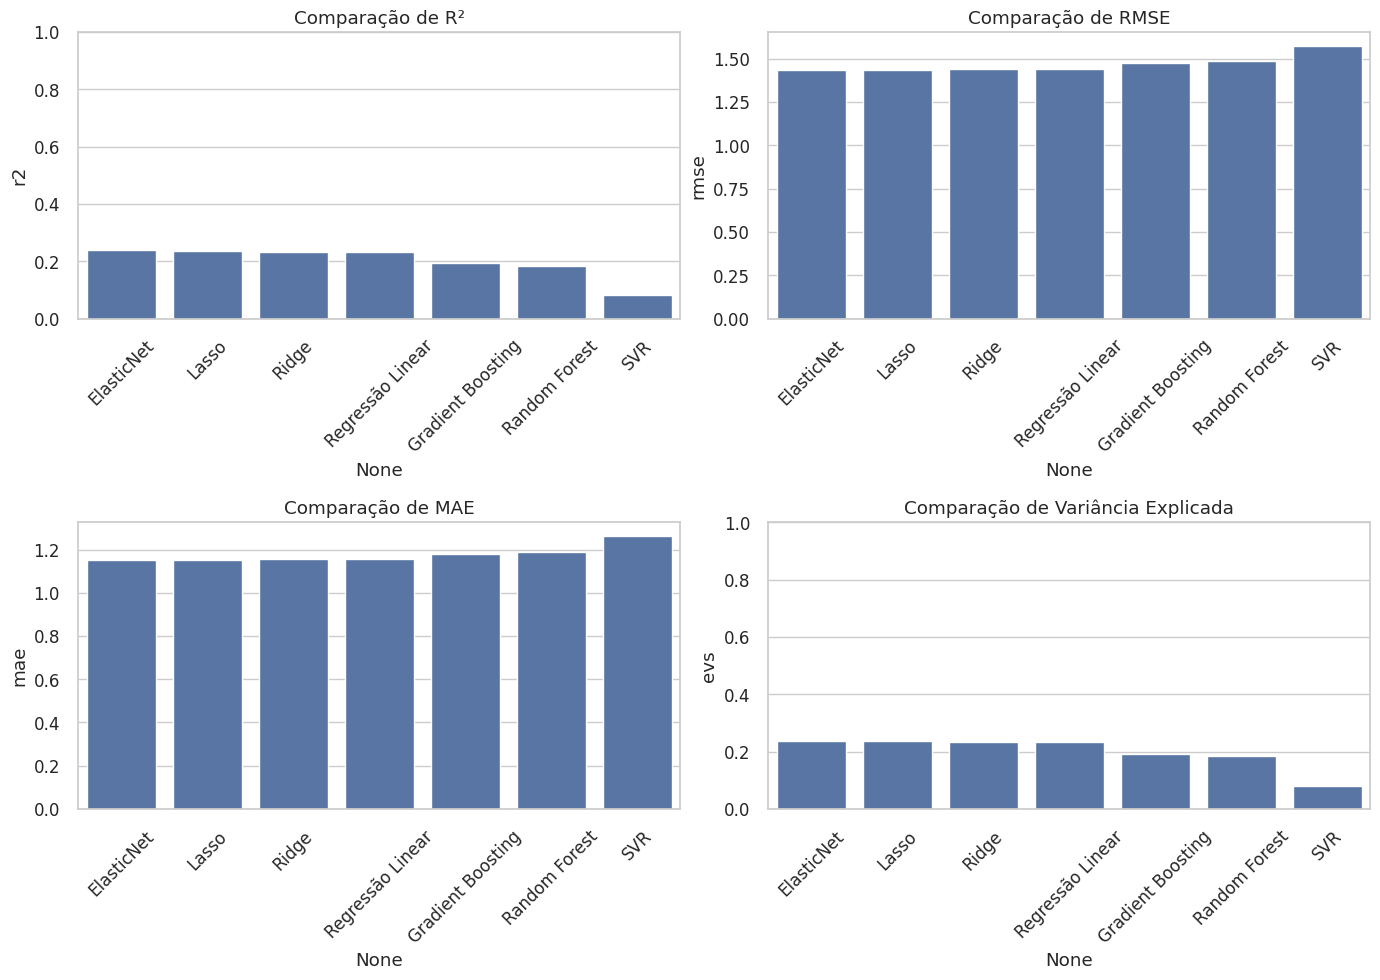

In [26]:
# Lista de modelos de regressão a serem testados
models = {
    'Regressão Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'SVR': SVR(kernel='rbf', C=10.0, gamma='scale', epsilon=0.2),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

# Treinamento e avaliação de cada modelo
results = {}
print("\n" + "="*70)
print("Treinando e avaliando modelos de regressão para diferença de gols...")
print("="*70)

for name, model in models.items():
    start_time = datetime.now()
    print(f"\nTreinando modelo {name}...")

    # Treina o modelo
    model.fit(X_train_selected, y_train)

    # Faz previsões no conjunto de teste
    y_pred = model.predict(X_test_selected)

    # Avalia o modelo
    eval_metrics = evaluate_regression_model(y_test, y_pred, name)
    results[name] = eval_metrics

    # Tempo de execução
    execution_time = datetime.now() - start_time
    print(f"Tempo de execução: {execution_time}")

    # Gera gráficos de resíduos para os modelos com melhor desempenho
    if eval_metrics['r2'] > 0.5:  # Ajuste esse limiar conforme necessário
        plot_residuals(y_test, y_pred, name)

# Criando DataFrame para comparação de métricas
metrics_df = pd.DataFrame.from_dict(results, orient='index')
# Ordenar por R²
metrics_df = metrics_df.sort_values('r2', ascending=False)

print("\nComparação de modelos (ordenado por R²):")
display(metrics_df[['r2', 'rmse', 'mae', 'evs']])

# Visualização comparativa dos modelos
plt.figure(figsize=(14, 10))

# R²
plt.subplot(2, 2, 1)
sns.barplot(x=metrics_df.index, y=metrics_df['r2'])
plt.title('Comparação de R²')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# RMSE
plt.subplot(2, 2, 2)
sns.barplot(x=metrics_df.index, y=metrics_df['rmse'])
plt.title('Comparação de RMSE')
plt.xticks(rotation=45)

# MAE
plt.subplot(2, 2, 3)
sns.barplot(x=metrics_df.index, y=metrics_df['mae'])
plt.title('Comparação de MAE')
plt.xticks(rotation=45)

# EVS
plt.subplot(2, 2, 4)
sns.barplot(x=metrics_df.index, y=metrics_df['evs'])
plt.title('Comparação de Variância Explicada')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Implementação e Avaliação do Random Forest


Realizando validação cruzada para os modelos de regressão...

Validação cruzada para Regressão Linear:
  Fold 1 - R²: 0.3002, RMSE: 1.4303, MAE: 1.1218
  Fold 2 - R²: 0.2536, RMSE: 1.4117, MAE: 1.1129
  Fold 3 - R²: 0.2282, RMSE: 1.5041, MAE: 1.1899
  Fold 4 - R²: 0.3080, RMSE: 1.3905, MAE: 1.1189
  Fold 5 - R²: 0.2787, RMSE: 1.3994, MAE: 1.1095
Médias para Regressão Linear:
  R² médio: 0.2737 (±0.0296)
  RMSE médio: 1.4272 (±0.0407)
  MAE médio: 1.1306 (±0.0300)

Validação cruzada para Ridge:
  Fold 1 - R²: 0.3001, RMSE: 1.4303, MAE: 1.1218
  Fold 2 - R²: 0.2536, RMSE: 1.4116, MAE: 1.1129
  Fold 3 - R²: 0.2282, RMSE: 1.5041, MAE: 1.1899
  Fold 4 - R²: 0.3080, RMSE: 1.3906, MAE: 1.1190
  Fold 5 - R²: 0.2787, RMSE: 1.3994, MAE: 1.1095
Médias para Ridge:
  R² médio: 0.2737 (±0.0296)
  RMSE médio: 1.4272 (±0.0407)
  MAE médio: 1.1306 (±0.0300)

Validação cruzada para Lasso:
  Fold 1 - R²: 0.2809, RMSE: 1.4498, MAE: 1.1506
  Fold 2 - R²: 0.2362, RMSE: 1.4280, MAE: 1.1253
  Fold 3 - R²: 0.

,R² Médio,RMSE Médio,MAE Médio,R² Desvio
Ridge,0.273736,1.427186,1.130610,0.029572
Regressão Linear,0.273729,1.427192,1.130611,0.029598
ElasticNet,0.263550,1.437275,1.139788,0.020660
Lasso,0.253228,1.447286,1.147782,0.021215
Gradient Boosting,0.226274,1.473331,1.163268,0.021357
Random Forest,0.209254,1.489594,1.176237,0.023692
SVR,0.117663,1.573495,1.246290,0.023505


<ipython-input-27-90e23c339bf2>:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data_r2, labels=cv_results_df.index)
<ipython-input-27-90e23c339bf2>:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data_rmse, labels=cv_results_df.index)
<ipython-input-27-90e23c339bf2>:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data_mae, labels=cv_results_df.index)


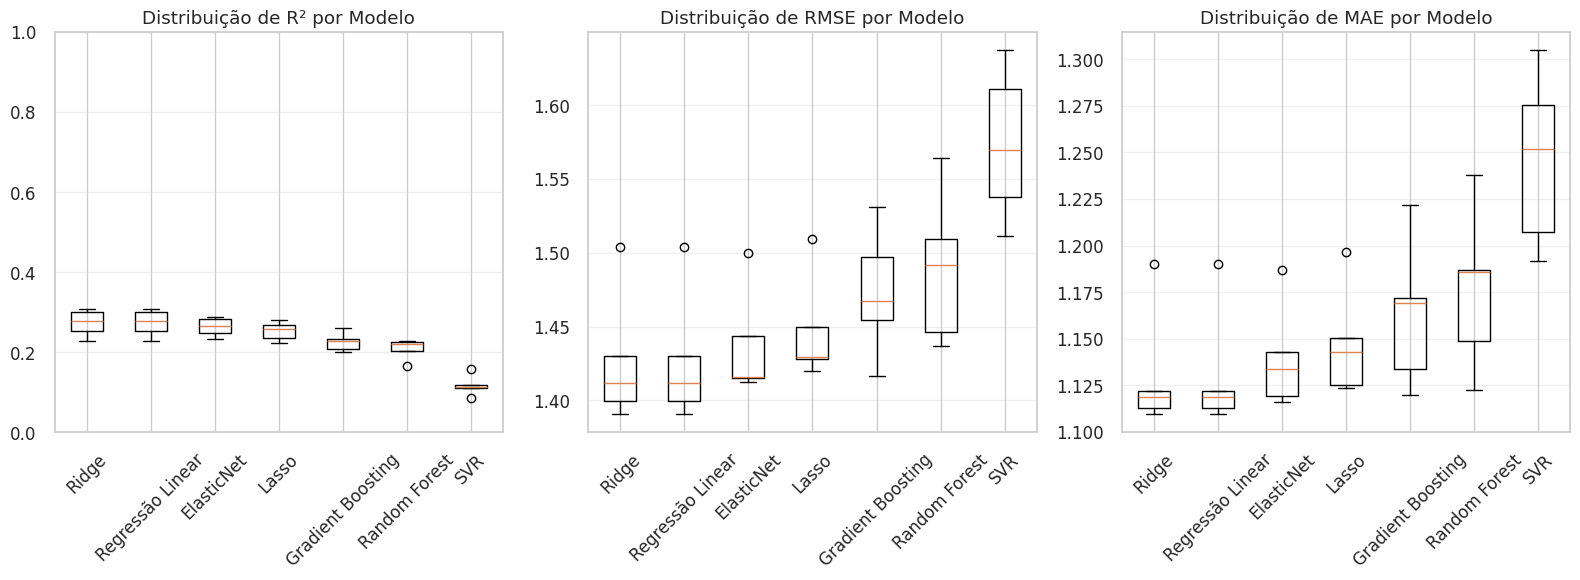

In [27]:
# Implementando validação cruzada para os modelos de regressão
print("\n" + "="*70)
print("Realizando validação cruzada para os modelos de regressão...")
print("="*70)

# Preparação dos dados para validação cruzada
X_full = X_train_selected
y_full = y_train

# Configuração da validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Métricas para cada modelo
cv_results = {model_name: {'r2': [], 'mse': [], 'rmse': [], 'mae': []} for model_name in models}

# Executando validação cruzada
for name, model in models.items():
    print(f"\nValidação cruzada para {name}:")

    cv_r2 = cross_val_score(model, X_full, y_full, cv=kf, scoring='r2')
    cv_neg_mse = cross_val_score(model, X_full, y_full, cv=kf, scoring='neg_mean_squared_error')
    cv_mse = -cv_neg_mse
    cv_rmse = np.sqrt(cv_mse)
    cv_mae = -cross_val_score(model, X_full, y_full, cv=kf, scoring='neg_mean_absolute_error')

    # Armazena os resultados
    cv_results[name]['r2'] = cv_r2
    cv_results[name]['mse'] = cv_mse
    cv_results[name]['rmse'] = cv_rmse
    cv_results[name]['mae'] = cv_mae

    # Imprime os resultados por fold
    for i, (r2, rmse, mae) in enumerate(zip(cv_r2, cv_rmse, cv_mae)):
        print(f"  Fold {i+1} - R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    # Calcula e imprime médias
    print(f"Médias para {name}:")
    print(f"  R² médio: {np.mean(cv_r2):.4f} (±{np.std(cv_r2):.4f})")
    print(f"  RMSE médio: {np.mean(cv_rmse):.4f} (±{np.std(cv_rmse):.4f})")
    print(f"  MAE médio: {np.mean(cv_mae):.4f} (±{np.std(cv_mae):.4f})")

# Criando DataFrame com as médias das métricas da validação cruzada
cv_results_df = pd.DataFrame({
    'R² Médio': [np.mean(cv_results[model]['r2']) for model in models],
    'RMSE Médio': [np.mean(cv_results[model]['rmse']) for model in models],
    'MAE Médio': [np.mean(cv_results[model]['mae']) for model in models],
    'R² Desvio': [np.std(cv_results[model]['r2']) for model in models],
}, index=list(models.keys()))

# Ordenar por R² Médio
cv_results_df = cv_results_df.sort_values('R² Médio', ascending=False)

print("\nResultados da Validação Cruzada (médias, ordenados por R²):")
display(cv_results_df)

# Visualização dos resultados da validação cruzada com boxplots
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
boxplot_data_r2 = [cv_results[model]['r2'] for model in cv_results_df.index]
plt.boxplot(boxplot_data_r2, labels=cv_results_df.index)
plt.title('Distribuição de R² por Modelo')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 2)
boxplot_data_rmse = [cv_results[model]['rmse'] for model in cv_results_df.index]
plt.boxplot(boxplot_data_rmse, labels=cv_results_df.index)
plt.title('Distribuição de RMSE por Modelo')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 3)
boxplot_data_mae = [cv_results[model]['mae'] for model in cv_results_df.index]
plt.boxplot(boxplot_data_mae, labels=cv_results_df.index)
plt.title('Distribuição de MAE por Modelo')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Implementação e Avaliação do Ensemble (Voting Classifier)


O melhor modelo conforme validação cruzada é: Ridge

Realizando análise de curvatura para visualizar relações não-lineares...

Top 10 features mais importantes:


,Feature,Importância
8,Diff_Chutes_Gol,0.110126
0,Chutes a gol 1,0.092031
1,Chutes a gol 2,0.029874
3,Chutes fora 1,0.010944
4,Cartões amarelos 1,0.009374
14,Time1_Form_4-2-3-1,0.006106
11,Eficiencia_Ofensiva_2,0.005397
2,Escanteios 2,0.004808
15,Time1_Form_4-3-3,0.004497
16,Time1_Form_4-5-1,0.003504


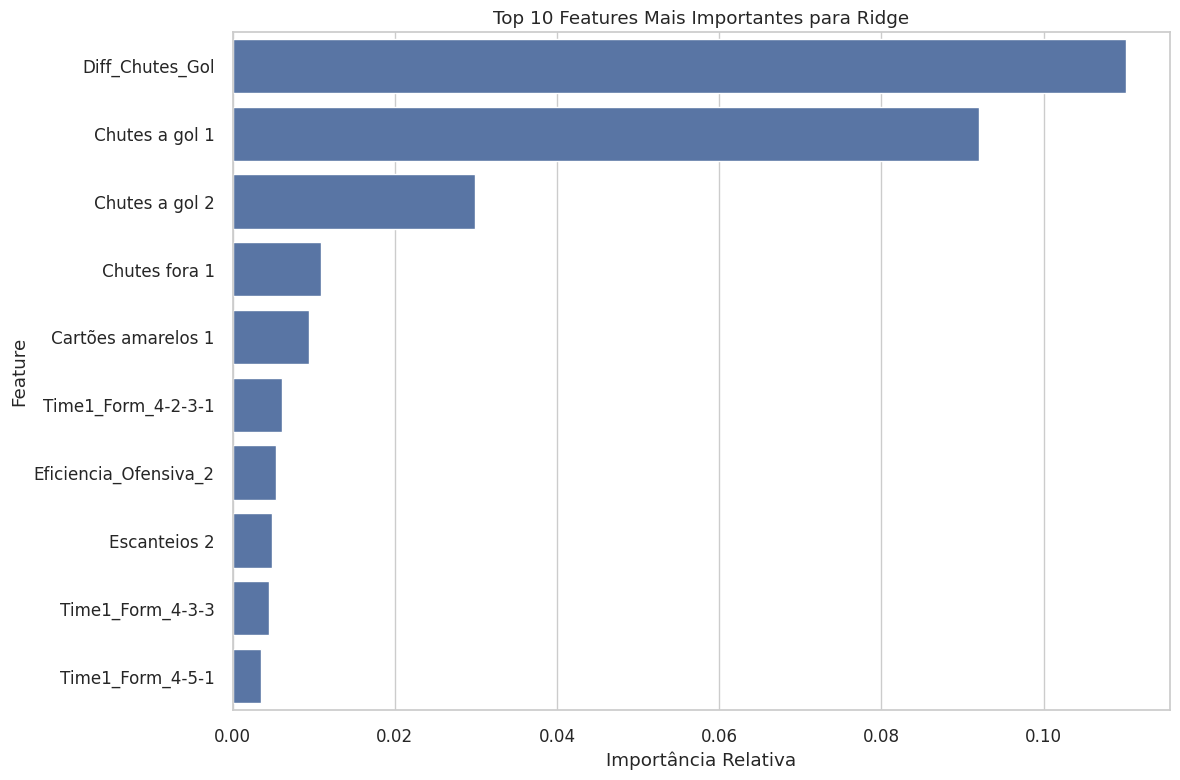

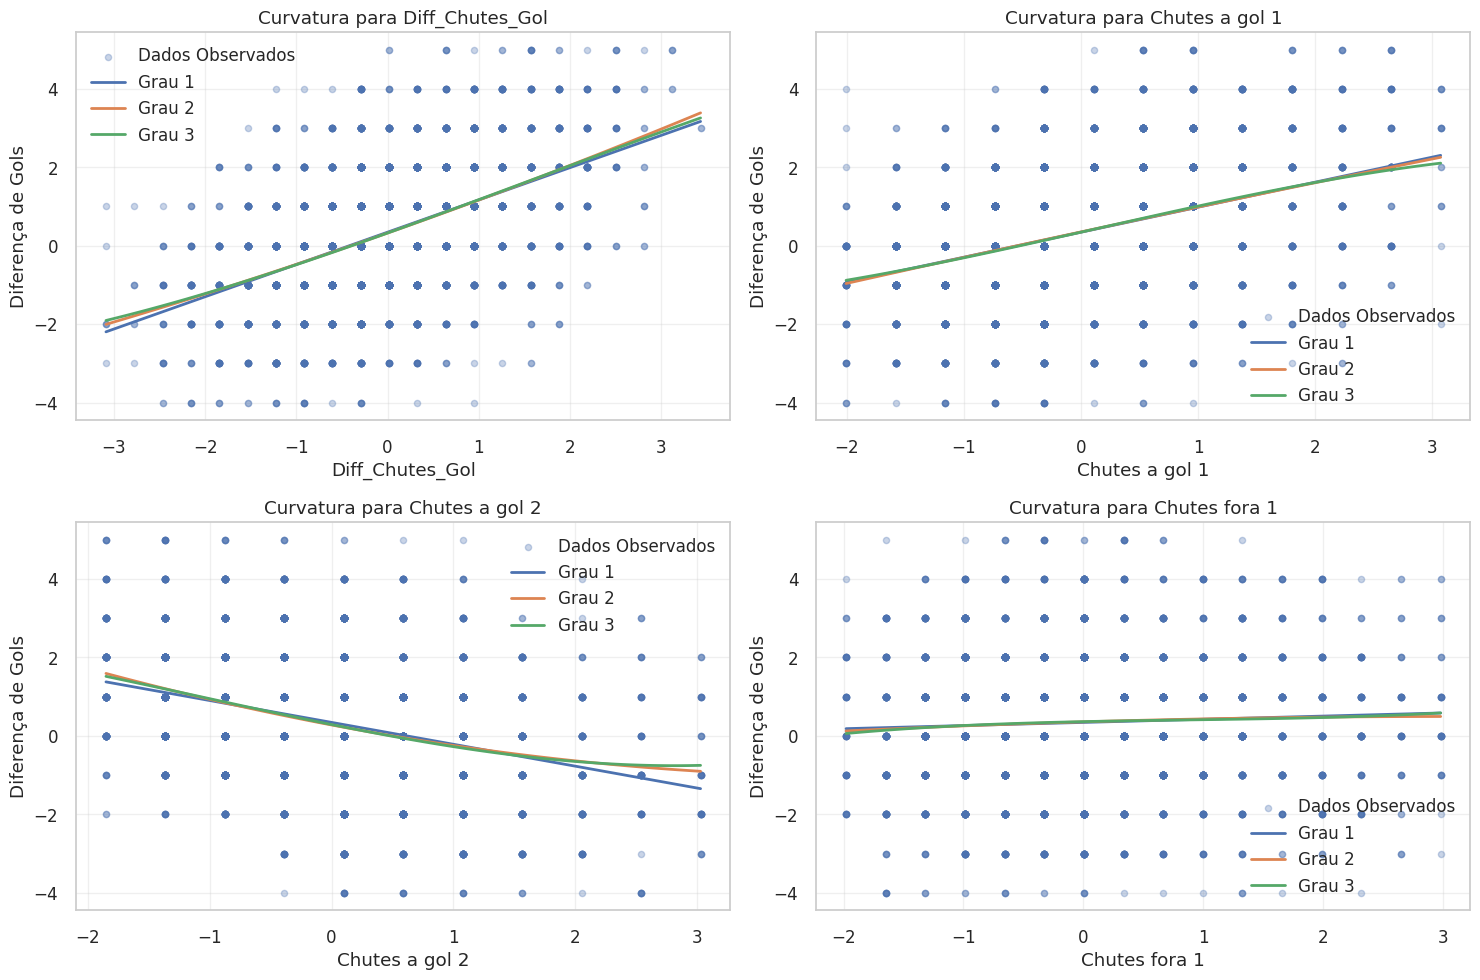

In [30]:
# Identificando o melhor modelo com base na validação cruzada
best_model_name = cv_results_df.index[0]
best_model = models[best_model_name]
print(f"\nO melhor modelo conforme validação cruzada é: {best_model_name}")

# Treinando o melhor modelo no conjunto completo de treino
best_model.fit(X_train_selected, y_train)

# 1. Análise de curvatura para features importantes
print("\nRealizando análise de curvatura para visualizar relações não-lineares...")

# Identificando as features mais importantes
if hasattr(best_model, 'feature_importances_'):
    # Para modelos como Random Forest e Gradient Boosting
    importances = best_model.feature_importances_
    feature_importances = pd.DataFrame({
        'Feature': [features[i] for i in selected_indices],
        'Importância': importances
    }).sort_values('Importância', ascending=False)
else:
    # Para outros modelos, usar permutation importance
    perm_importance = permutation_importance(best_model, X_test_selected, y_test, n_repeats=10, random_state=42)
    feature_importances = pd.DataFrame({
        'Feature': [features[i] for i in selected_indices],
        'Importância': perm_importance.importances_mean
    }).sort_values('Importância', ascending=False)

print("\nTop 10 features mais importantes:")
display(feature_importances.head(10))

# Visualizando a importância das features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importância', y='Feature', data=feature_importances.head(10))
plt.title(f'Top 10 Features Mais Importantes para {best_model_name}')
plt.xlabel('Importância Relativa')
plt.tight_layout()
plt.show()

# Análise de curvatura para as top 4 features mais importantes
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(15, 10))
top_features = feature_importances.head(4)['Feature'].tolist()

for i, feature_name in enumerate(top_features):
    # Encontrar o índice da feature no conjunto original
    try:
        feature_idx = features.index(feature_name)

        # Extrair os valores originais da feature
        feature_values = X.iloc[:, feature_idx].values.reshape(-1, 1)

        # CORREÇÃO: Criar um novo scaler apenas para esta feature
        feature_scaler = StandardScaler()
        feature_scaled = feature_scaler.fit_transform(feature_values)[:, 0]

        plt.subplot(2, 2, i+1)

        # Plotando os dados originais
        plt.scatter(feature_scaled, y, alpha=0.3, s=20, label='Dados Observados')

        # Ajustando polinômios de graus diferentes
        x_plot = np.linspace(min(feature_scaled), max(feature_scaled), 100).reshape(-1, 1)

        for degree in [1, 2, 3]:
            model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
            model.fit(feature_scaled.reshape(-1, 1), y)
            y_plot = model.predict(x_plot)
            plt.plot(x_plot, y_plot, linewidth=2, label=f'Grau {degree}')

        plt.title(f'Curvatura para {feature_name}')
        plt.xlabel(feature_name)
        plt.ylabel('Diferença de Gols')
        plt.grid(alpha=0.3)
        plt.legend()
    except (ValueError, IndexError) as e:
        print(f"Erro ao processar feature {feature_name}: {e}")
        continue

plt.tight_layout()
plt.show()

Comparação dos Modelos e Avaliação Final


Otimizando hiperparâmetros para Ridge...
Iniciando busca em grade para Ridge às 17:20:13
Este processo pode levar alguns minutos...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Busca em grade concluída em 0:00:05.479023

Melhores hiperparâmetros encontrados:
{'alpha': 100, 'solver': 'auto'}
Melhor score R²: 0.2783

Avaliação do modelo otimizado:
Avaliação do Ridge Otimizado:
R² (Coeficiente de Determinação): 0.2331
MSE (Erro Quadrático Médio): 2.0709
RMSE (Raiz do Erro Quadrático Médio): 1.4391
MAE (Erro Absoluto Médio): 1.1559
MedAE (Erro Absoluto Mediano): 0.9863
MAPE (Erro Percentual Absoluto Médio): 82.6599%
SMAPE (Erro Percentual Absoluto Médio Simétrico): 120.1390%
EVS (Variância Explicada): 0.2331


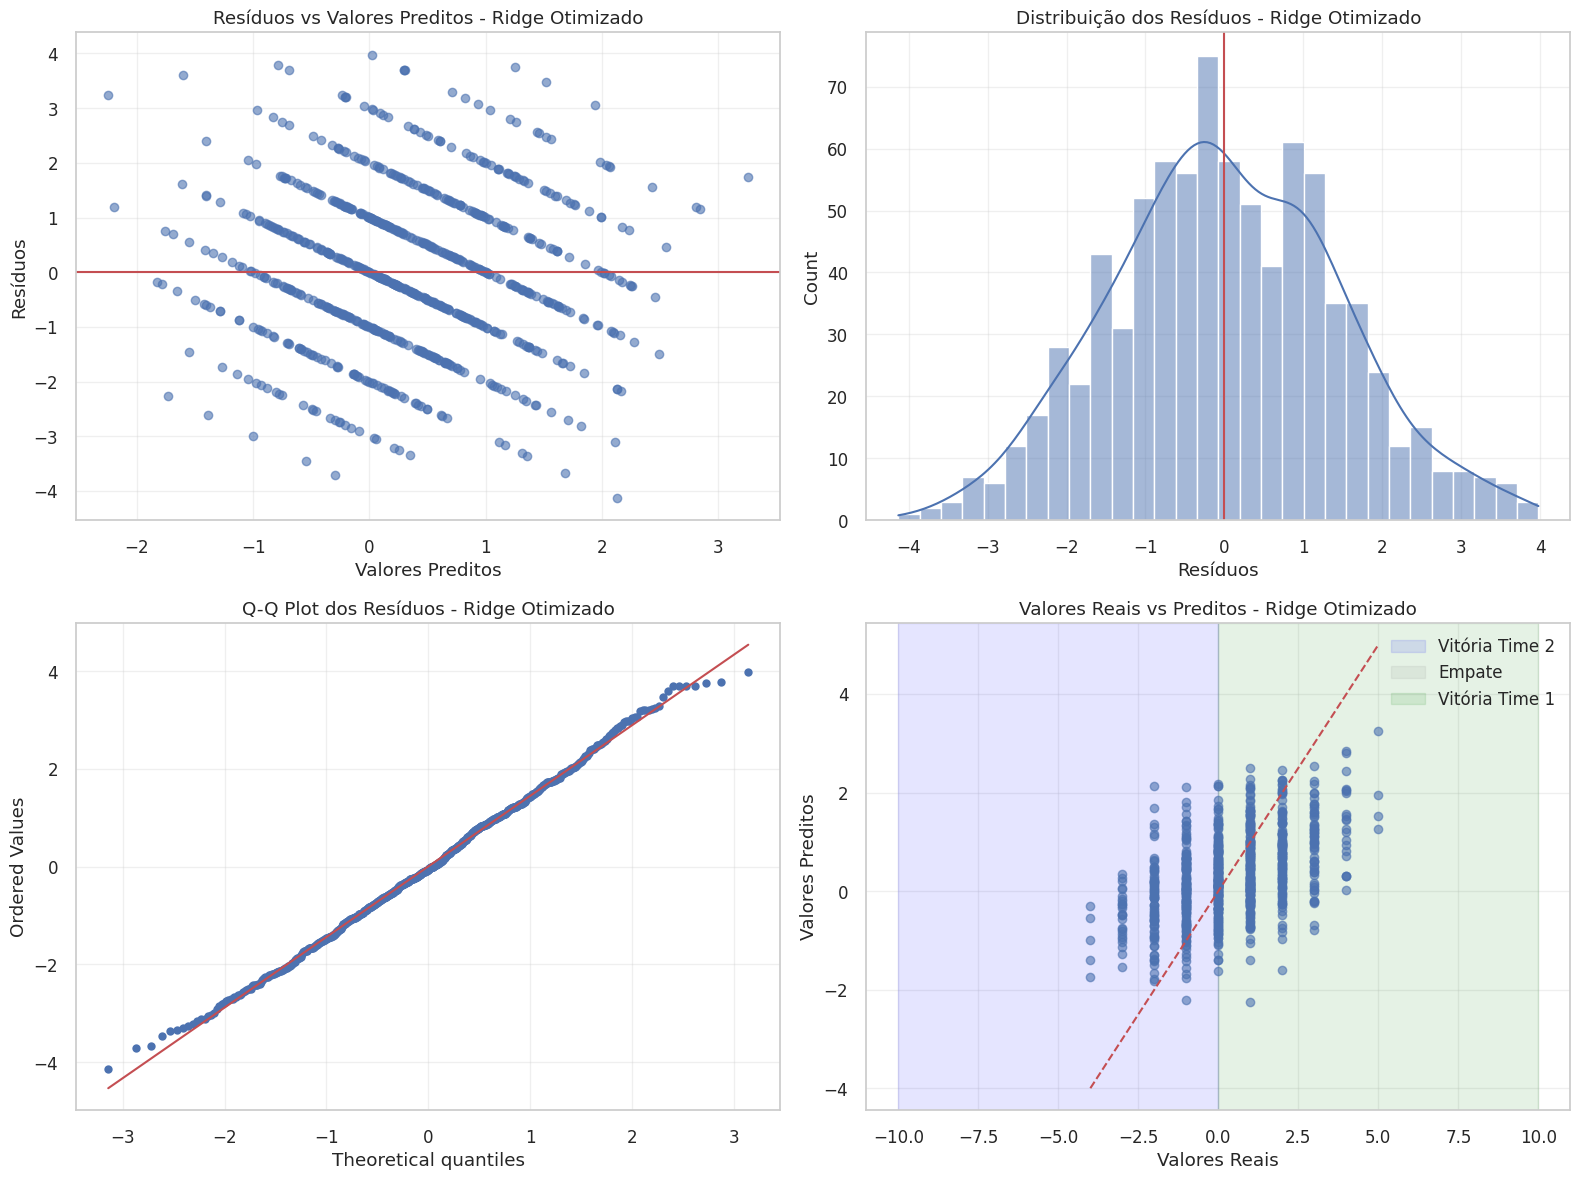

Avaliação do Ridge Original:
R² (Coeficiente de Determinação): 0.2326
MSE (Erro Quadrático Médio): 2.0722
RMSE (Raiz do Erro Quadrático Médio): 1.4395
MAE (Erro Absoluto Médio): 1.1568
MedAE (Erro Absoluto Mediano): 0.9921
MAPE (Erro Percentual Absoluto Médio): 82.8197%
SMAPE (Erro Percentual Absoluto Médio Simétrico): 119.8899%
EVS (Variância Explicada): 0.2326

Comparação antes e depois da otimização:


,Métrica,Antes da otimização,Após otimização,Melhoria (%)
0,R²,0.232638,0.233128,0.210689
1,RMSE,1.439527,1.439067,0.031942
2,MAE,1.156827,1.155918,0.078626


In [31]:
# Otimização de hiperparâmetros para o melhor modelo
print("\n" + "="*70)
print(f"Otimizando hiperparâmetros para {best_model_name}...")
print("="*70)

# Definindo grade de hiperparâmetros com base no modelo
param_grid = {}
if best_model_name == 'Ridge':
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
    }
elif best_model_name == 'Lasso':
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'max_iter': [1000, 2000, 3000]
    }
elif best_model_name == 'ElasticNet':
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'max_iter': [1000, 2000]
    }
elif best_model_name == 'SVR':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'kernel': ['linear', 'rbf'],
        'epsilon': [0.01, 0.1, 0.2, 0.5]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }

if param_grid:
    start_time = datetime.now()
    print(f"Iniciando busca em grade para {best_model_name} às {start_time.strftime('%H:%M:%S')}")
    print("Este processo pode levar alguns minutos...")

    # Configurando e executando a busca em grade
    grid_search = GridSearchCV(
        estimator=models[best_model_name],
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_selected, y_train)

    end_time = datetime.now()
    print(f"Busca em grade concluída em {end_time - start_time}")

    # Resultados da busca em grade
    print(f"\nMelhores hiperparâmetros encontrados:")
    print(grid_search.best_params_)
    print(f"Melhor score R²: {grid_search.best_score_:.4f}")

    # Modelo otimizado
    best_model_tuned = grid_search.best_estimator_

    # Avaliando o modelo otimizado
    y_pred_tuned = best_model_tuned.predict(X_test_selected)
    print("\nAvaliação do modelo otimizado:")
    tuned_metrics = evaluate_regression_model(y_test, y_pred_tuned, f"{best_model_name} Otimizado")

    # Gráficos de resíduos para o modelo otimizado
    plot_residuals(y_test, y_pred_tuned, f"{best_model_name} Otimizado")

    # Comparação antes e depois da otimização
    y_pred_original = best_model.predict(X_test_selected)
    original_metrics = evaluate_regression_model(y_test, y_pred_original, f"{best_model_name} Original")

    comparison = pd.DataFrame({
        'Métrica': ['R²', 'RMSE', 'MAE'],
        'Antes da otimização': [original_metrics['r2'], original_metrics['rmse'], original_metrics['mae']],
        'Após otimização': [tuned_metrics['r2'], tuned_metrics['rmse'], tuned_metrics['mae']],
        'Melhoria (%)': [
            (tuned_metrics['r2'] - original_metrics['r2']) / abs(original_metrics['r2']) * 100 if original_metrics['r2'] != 0 else np.inf,
            (original_metrics['rmse'] - tuned_metrics['rmse']) / original_metrics['rmse'] * 100,
            (original_metrics['mae'] - tuned_metrics['mae']) / original_metrics['mae'] * 100
        ]
    })

    print("\nComparação antes e depois da otimização:")
    display(comparison)
else:
    print(f"O modelo {best_model_name} não possui parâmetros significativos para otimizar ou é um modelo base.")
    best_model_tuned = best_model

Otimização de Hiperparâmetros para o Melhor Modelo


Aplicando o modelo final para predição de resultados
Acurácia na previsão do resultado: 0.5366

Matriz de Confusão:
[[144   0 110]
 [ 71   0 131]
 [ 74   0 303]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      0.57      0.53       254
           1       0.00      0.00      0.00       202
           2       0.56      0.80      0.66       377

    accuracy                           0.54       833
   macro avg       0.35      0.46      0.40       833
weighted avg       0.40      0.54      0.46       833



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


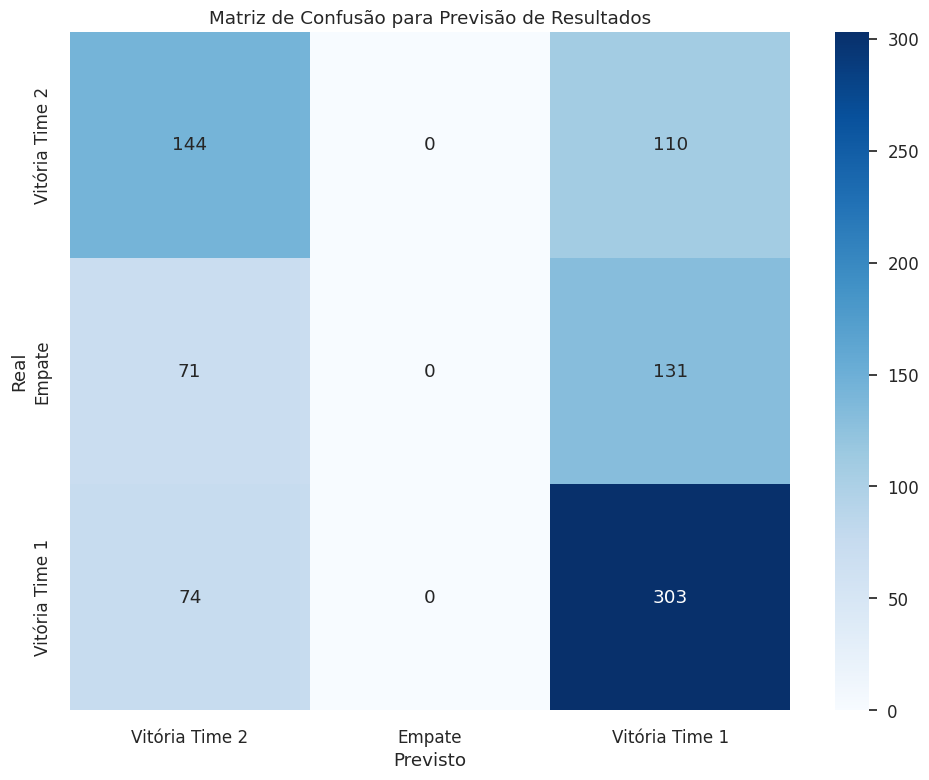


Taxa de acertos por resultado:
Resultado Real
0    0.566929
1    0.000000
2    0.803714
Name: Acerto, dtype: float64


<ipython-input-32-fb3d22ab781f>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acertos_por_resultado.index, y=acertos_por_resultado.values,


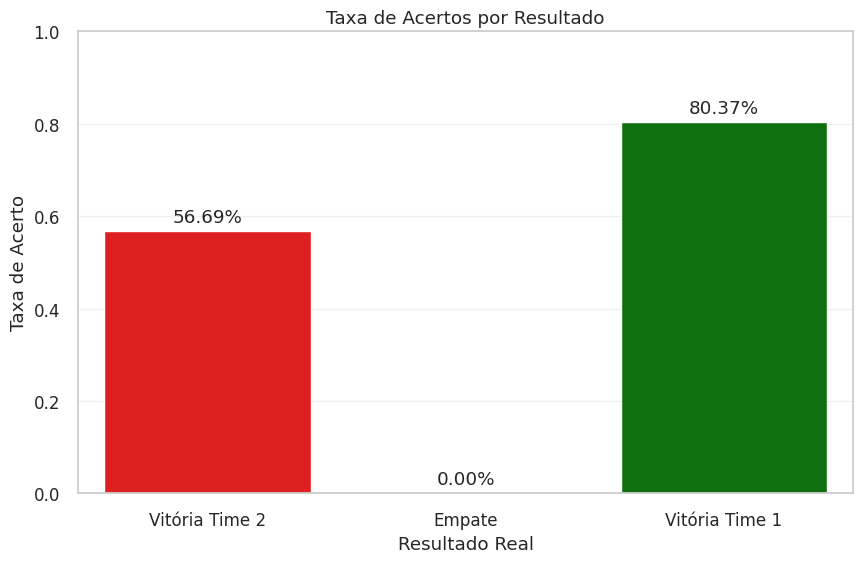

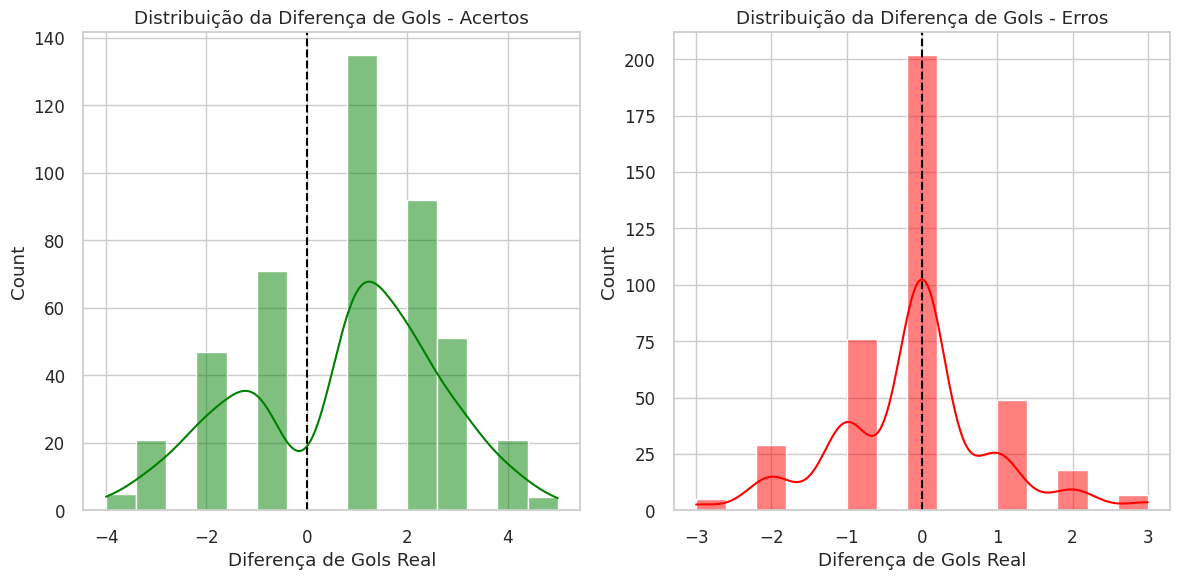

In [32]:
# Usando o modelo otimizado para predição final
print("\n" + "="*70)
print("Aplicando o modelo final para predição de resultados")
print("="*70)

# Temos duas abordagens para prever resultados:
# 1. Usar o modelo de regressão para prever a diferença de gols e converter para resultado
# 2. Treinar um modelo de classificação diretamente (já implementado em blocos anteriores)

# Vamos implementar a abordagem 1 usando o melhor modelo de regressão otimizado

# Função para converter diferença de gols para resultado
def diferenca_para_resultado(diff_gols):
    if diff_gols > 0:
        return 2  # Vitória Time 1
    elif diff_gols < 0:
        return 0  # Vitória Time 2
    else:
        return 1  # Empate

# Predições finais com o modelo otimizado
y_pred_diff = best_model_tuned.predict(X_test_selected)

# Convertendo previsões contínuas para resultados discretos
y_pred_result = np.array([diferenca_para_resultado(diff) for diff in y_pred_diff])
y_test_result = np.array([diferenca_para_resultado(diff) for diff in y_test.values])

# Calculando métricas de classificação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test_result, y_pred_result)
conf_matrix = confusion_matrix(y_test_result, y_pred_result)
class_report = classification_report(y_test_result, y_pred_result)

print(f"Acurácia na previsão do resultado: {accuracy:.4f}")
print("\nMatriz de Confusão:")
print(conf_matrix)
print("\nRelatório de Classificação:")
print(class_report)

# Visualizando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Vitória Time 2', 'Empate', 'Vitória Time 1'],
            yticklabels=['Vitória Time 2', 'Empate', 'Vitória Time 1'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão para Previsão de Resultados')
plt.tight_layout()
plt.show()

# Análise de acertos e erros
df_predictions = pd.DataFrame({
    'Diferença Real': y_test,
    'Diferença Prevista': y_pred_diff,
    'Resultado Real': y_test_result,
    'Resultado Previsto': y_pred_result,
    'Acerto': y_test_result == y_pred_result
})

# Estatísticas básicas
acertos_por_resultado = df_predictions.groupby('Resultado Real')['Acerto'].mean()
print("\nTaxa de acertos por resultado:")
print(acertos_por_resultado)

# Gráfico de acertos por resultado
plt.figure(figsize=(10, 6))
sns.barplot(x=acertos_por_resultado.index, y=acertos_por_resultado.values,
            palette=['red', 'gray', 'green'])
plt.xticks([0, 1, 2], ['Vitória Time 2', 'Empate', 'Vitória Time 1'])
plt.title('Taxa de Acertos por Resultado')
plt.ylabel('Taxa de Acerto')
plt.xlabel('Resultado Real')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(acertos_por_resultado):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')

plt.ylim(0, 1.0)
plt.show()

# Distribuição de erros por magnitude da diferença de gols
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df_predictions[df_predictions['Acerto']], x='Diferença Real',
             color='green', label='Acertos', bins=15, kde=True)
plt.title('Distribuição da Diferença de Gols - Acertos')
plt.xlabel('Diferença de Gols Real')
plt.axvline(x=0, color='black', linestyle='--')

plt.subplot(1, 2, 2)
sns.histplot(data=df_predictions[~df_predictions['Acerto']], x='Diferença Real',
             color='red', label='Erros', bins=15, kde=True)
plt.title('Distribuição da Diferença de Gols - Erros')
plt.xlabel('Diferença de Gols Real')
plt.axvline(x=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

Exemplo de Previsão com o Modelo Otimizad


Análise dos casos em que o modelo errou na previsão
Total de erros: 386 de 833 (46.34%)

Erros em empates: 202 (52.33% dos erros)
Erros em vitórias do time da casa: 74 (19.17% dos erros)
Erros em vitórias do time visitante: 110 (28.50% dos erros)

Distribuição dos tipos de erros:


Previsto,0,2
Real,,
0,0,110
1,71,131
2,74,0



Estatísticas da diferença de gols nos casos de erro:
count    386.000000
mean      -0.111399
std        1.039743
min       -3.000000
25%       -1.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: Diferença Real, dtype: float64


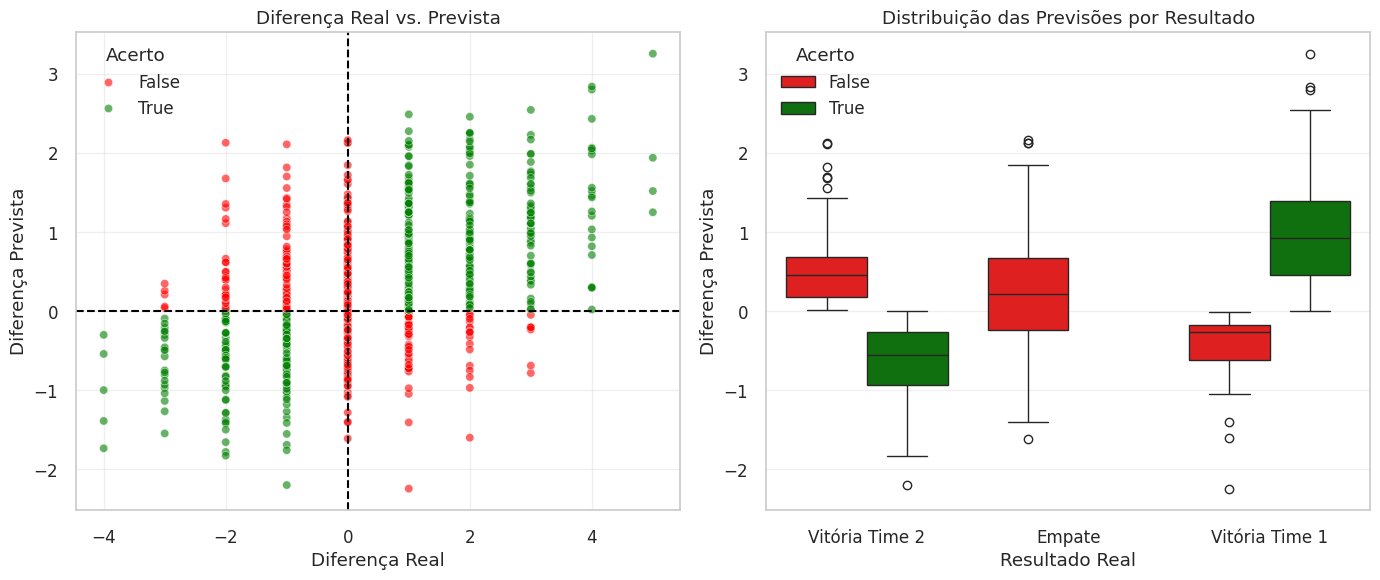


CONCLUSÕES FINAIS

1. O melhor modelo de regressão foi Ridge com R² de 0.2331
2. Taxa de acerto na previsão de resultados: 53.66%
3. O modelo teve maior dificuldade em prever corretamente: 1
4. O modelo teve melhor desempenho em prever: 2

5. As 5 features mais importantes para o modelo foram:
   1. Diff_Chutes_Gol: 0.1101
   2. Chutes a gol 1: 0.0920
   3. Chutes a gol 2: 0.0299
   4. Chutes fora 1: 0.0109
   5. Cartões amarelos 1: 0.0094

RECOMENDAÇÕES:
• Considere adicionar mais features históricas (forma recente, confrontos diretos)
• Explore modelos de ensemble combinando regressão e classificação
• Utilize técnicas de calibração de probabilidades para melhorar a previsão de empates
• Aplique engenharia de features específica para prever empates, que são mais difíceis de acertar
• Considere o uso de séries temporais para capturar tendências ao longo da temporada

Estudo realizado por: perrijuan
Data: 2025-04-20 17:20:38


In [33]:
# Analisando casos em que o modelo errou
print("\n" + "="*70)
print("Análise dos casos em que o modelo errou na previsão")
print("="*70)

erros = df_predictions[~df_predictions['Acerto']]
print(f"Total de erros: {len(erros)} de {len(df_predictions)} ({len(erros)/len(df_predictions):.2%})")

# Tipos de erros específicos
erros_empate_vitoria = erros[(erros['Resultado Real'] == 1) & (erros['Resultado Previsto'] != 1)]
print(f"\nErros em empates: {len(erros_empate_vitoria)} ({len(erros_empate_vitoria)/len(erros):.2%} dos erros)")

erros_vitoria_casa = erros[(erros['Resultado Real'] == 2) & (erros['Resultado Previsto'] != 2)]
print(f"Erros em vitórias do time da casa: {len(erros_vitoria_casa)} ({len(erros_vitoria_casa)/len(erros):.2%} dos erros)")

erros_vitoria_fora = erros[(erros['Resultado Real'] == 0) & (erros['Resultado Previsto'] != 0)]
print(f"Erros em vitórias do time visitante: {len(erros_vitoria_fora)} ({len(erros_vitoria_fora)/len(erros):.2%} dos erros)")

# Analisando erros por tipo de previsão incorreta
erros_tipos = pd.crosstab(erros['Resultado Real'], erros['Resultado Previsto'],
                         rownames=['Real'], colnames=['Previsto'])

print("\nDistribuição dos tipos de erros:")
display(erros_tipos)

# Diferença de gols nos casos de erro
print("\nEstatísticas da diferença de gols nos casos de erro:")
print(erros['Diferença Real'].describe())

# Visualização da distribuição de erros
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_predictions, x='Diferença Real', y='Diferença Prevista',
                hue='Acerto', palette={True: 'green', False: 'red'}, alpha=0.6)
plt.title('Diferença Real vs. Prevista')
plt.grid(alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')

plt.subplot(1, 2, 2)
sns.boxplot(x='Resultado Real', y='Diferença Prevista', data=df_predictions,
            hue='Acerto', palette={True: 'green', False: 'red'})
plt.title('Distribuição das Previsões por Resultado')
plt.xticks([0, 1, 2], ['Vitória Time 2', 'Empate', 'Vitória Time 1'])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Conclusões finais
print("\n" + "="*70)
print("CONCLUSÕES FINAIS")
print("="*70)

print(f"\n1. O melhor modelo de regressão foi {best_model_name} com R² de {tuned_metrics['r2']:.4f}")
print(f"2. Taxa de acerto na previsão de resultados: {accuracy:.2%}")
print(f"3. O modelo teve maior dificuldade em prever corretamente: {acertos_por_resultado.idxmin()}")
print(f"4. O modelo teve melhor desempenho em prever: {acertos_por_resultado.idxmax()}")

# Features mais importantes
print("\n5. As 5 features mais importantes para o modelo foram:")
for i, (feature, importance) in enumerate(zip(feature_importances['Feature'].head(5),
                                              feature_importances['Importância'].head(5))):
    print(f"   {i+1}. {feature}: {importance:.4f}")


print(f"Data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")